In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import label_binarize 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_curve, auc, precision_recall_curve, 
                             confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, 
                             classification_report, recall_score, balanced_accuracy_score, f1_score, precision_score)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Normalization

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\cancer.csv")
df = df.drop(columns=df[['id','Unnamed: 32']])
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
ordinal_mapping = {
    'M': 0,
    'B': 1,
}

In [4]:
df['diagnosis'] = df['diagnosis'].replace(ordinal_mapping)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
print(df['diagnosis'].value_counts())

diagnosis
1    357
0    212
Name: count, dtype: int64


In [6]:
x = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify =y)

In [8]:
normalizer = Normalization(axis=-1)
normalizer.adapt(x_train)
x_train_adapt = normalizer(x_train)
x_test_adapt = normalizer(x_test)

In [9]:
class_weights = dict(enumerate(
    compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
))

In [10]:
def build_model_wide_deep_hyperband(hp):
    input_layer = tf.keras.layers.Input(shape=(x_train_adapt.shape[1],))
    wide = tf.keras.layers.Dense(1, activation='linear')(input_layer)
    deep = input_layer
    for i in range(hp.Int('num_layers', 1, 3)):
        deep = tf.keras.layers.Dense(units=hp.Int(f'units_{i}', min_value = 16, max_value = 128, step=8),
                                     activation = hp.Choice('activation',['relu','tanh']))(deep)
        deep = tf.keras.layers.BatchNormalization()(deep)
        deep = tf.keras.layers.Dropout(
            rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
        )(deep)

    combined = tf.keras.layers.concatenate([wide, deep])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)

    model = tf.keras.Model(inputs = input_layer, outputs = output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr',[0.01, 0.001])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
hyperband_tune = kt.Hyperband(
    build_model_wide_deep_hyperband,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='hyperband_wdc',
    project_name='cancer_hyperband'
)

In [12]:
hyperband_tune.search(x_train_adapt, y_train,
                      validation_split=0.2, batch_size=18,
                      verbose=True)

Trial 90 Complete [00h 00m 46s]
val_accuracy: 0.9890109896659851

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 40m 42s


In [23]:
top_hps = hyperband_tune.get_best_hyperparameters(num_trials=1)[0]

In [26]:
def build_model_wide_deep_bayesian(hp):
    input_layer = tf.keras.layers.Input(shape=(x_train_adapt.shape[1],))
    wide = tf.keras.layers.Dense(1, activation='linear')(input_layer)
    deep = input_layer
    for i in range(top_hps.get('num_layers')):
        deep = tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', 
                         min_value=min(16, top_hps.get(f'units_{i}') - 16),
                         max_value=max(128, top_hps.get(f'units_{i}') + 16),
                         step=8),
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])
        )(deep)
        deep = tf.keras.layers.BatchNormalization()(deep)
        deep = tf.keras.layers.Dropout(
            rate=hp.Float(f'dropout_rate_{i}', 
                          min_value=min(0.1, top_hps.get(f'dropout_rate_{i}') - 0.1),
                          max_value=max(0.5, top_hps.get(f'dropout_rate_{i}') + 0.1),
                          step=0.1))(deep)
    combined = tf.keras.layers.concatenate([wide, deep])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', 
                                                                   [top_hps.get('lr') * 0.1,
                                                                    top_hps.get('lr'),
                                                                    top_hps.get('lr') * 10])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [27]:
bayesian_tune = kt.BayesianOptimization(
    build_model_wide_deep_bayesian,
    objective='val_accuracy',
    max_trials=10,
    directory='bayes_tuner',
    project_name='cancer_bayes'
)

In [28]:
bayesian_tune.search(x_train_adapt, y_train,
                     validation_split=0.2, epochs=30,
                     batch_size=18, verbose=True,
                     )

Trial 10 Complete [00h 00m 25s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 57s


In [29]:
best_hps = bayesian_tune.get_best_hyperparameters(num_trials=1)[0]

In [30]:
best_model = bayesian_tune.hypermodel.build(best_hps)

In [31]:
history = best_model.fit(x_train_adapt, y_train,
                         validation_split=0.2,
                         epochs=30,
                         batch_size=16,
                         class_weight=class_weights,
                         verbose=True)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7114 - loss: 0.4724 - val_accuracy: 0.9890 - val_loss: 0.0615
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9452 - loss: 0.1722 - val_accuracy: 0.9890 - val_loss: 0.0531
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9537 - loss: 0.1109 - val_accuracy: 0.9780 - val_loss: 0.0746
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9779 - loss: 0.1002 - val_accuracy: 0.9890 - val_loss: 0.0417
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9683 - loss: 0.1035 - val_accuracy: 0.9890 - val_loss: 0.0426
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9750 - loss: 0.1070 - val_accuracy: 0.9890 - val_loss: 0.0453
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9698 - loss: 0.0947 - val_accuracy: 0.9890 - val_loss: 0.0415
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9948 - loss: 0.0365 - val_accuracy: 0.9890 - val_l

In [32]:
y_predict = best_model.predict(x_test_adapt)
y_pred = (y_predict >= 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [33]:
print(y_predict)
print(y_pred)

[[1.06141103e-11]
 [1.00000000e+00]
 [3.61290654e-06]
 [3.72935653e-01]
 [7.40208646e-16]
 [9.99979198e-01]
 [9.99999940e-01]
 [1.20640817e-10]
 [5.51579715e-09]
 [8.03685083e-16]
 [9.99982715e-01]
 [7.48277955e-07]
 [9.99997020e-01]
 [7.95840727e-10]
 [4.72957176e-08]
 [9.97223854e-01]
 [4.44174856e-01]
 [9.29250121e-01]
 [1.00000000e+00]
 [9.99791801e-01]
 [8.51037726e-07]
 [9.18746693e-04]
 [9.99999940e-01]
 [9.99971926e-01]
 [9.99938846e-01]
 [9.97463286e-01]
 [1.12023487e-12]
 [9.99994814e-01]
 [9.99997854e-01]
 [9.99882519e-01]
 [9.99993682e-01]
 [1.00000000e+00]
 [9.99969065e-01]
 [9.20195222e-01]
 [2.62646738e-10]
 [4.42647986e-04]
 [9.99997914e-01]
 [9.19581652e-01]
 [4.94535565e-02]
 [1.01912745e-09]
 [9.99999940e-01]
 [9.99999881e-01]
 [9.99975324e-01]
 [6.06036022e-15]
 [3.09555645e-07]
 [9.05363977e-01]
 [1.00000000e+00]
 [9.99999821e-01]
 [9.99821126e-01]
 [3.21038591e-08]
 [9.99999702e-01]
 [3.38149041e-01]
 [9.99996364e-01]
 [9.98317361e-01]
 [9.91700947e-01]
 [9.999996

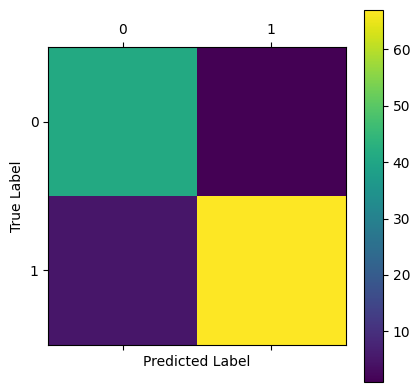

In [34]:
matrix = confusion_matrix(y_test, y_pred)

plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Text(113.9222222222222, 0.5, 'true value')

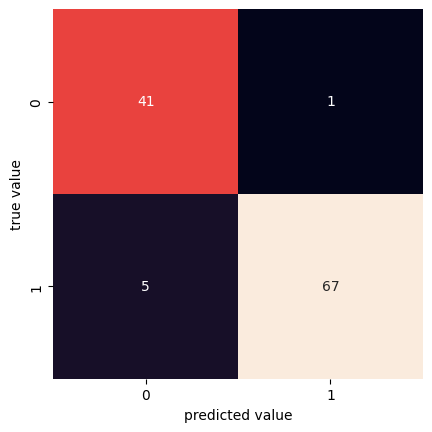

In [35]:
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [36]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9473684210526315

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        42
           1       0.99      0.93      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.9927248677248677


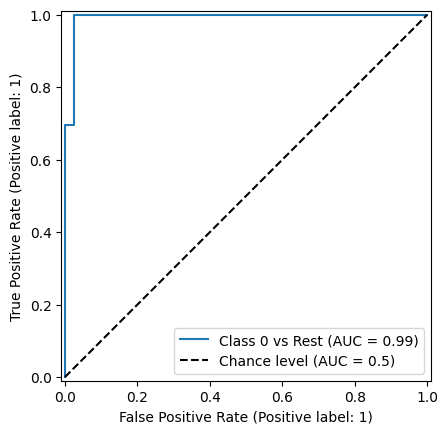

In [37]:
y_prob = best_model.predict(x_test_adapt)

roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(roc_auc_ovr)
classes = np.unique(y_test)

y_test_bin = label_binarize(y_test, classes = classes)
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

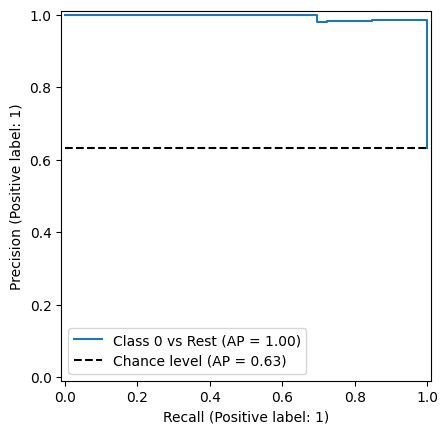

In [38]:
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
    pr_auc[i] = auc(recall[i], precision[i])
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

In [39]:
print("\nModel Evaluation:")
results = best_model.evaluate(x_test_adapt, y_test, verbose=0)
metrics = dict(zip(best_model.metrics_names, results))
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Model Evaluation:
loss: 0.1377
compile_metrics: 0.9474


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


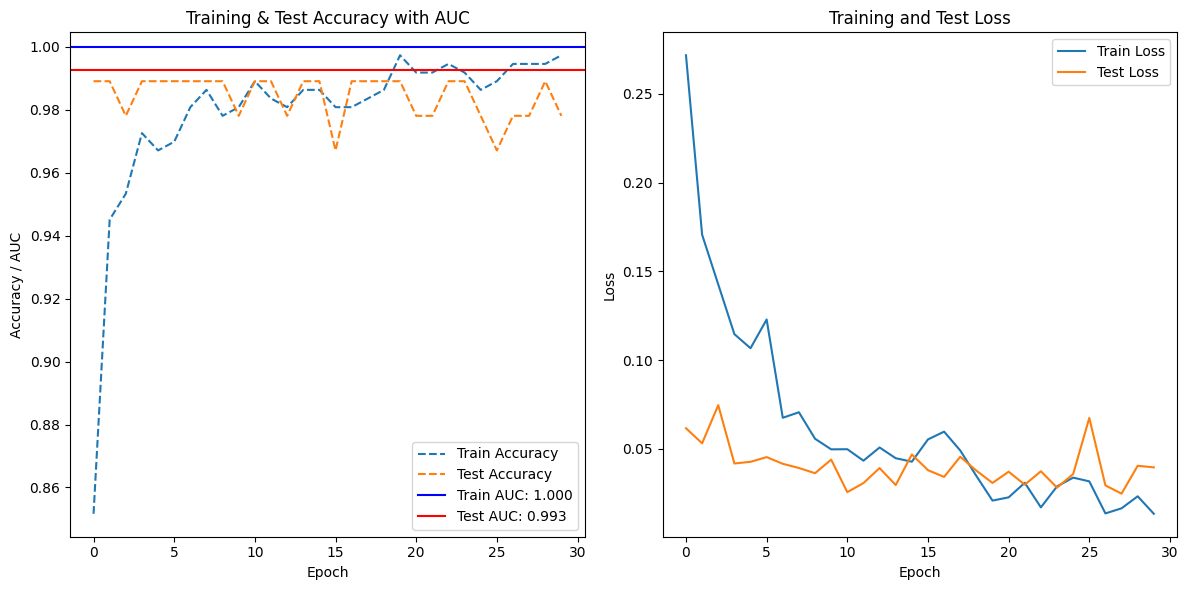

In [40]:
y_train_pred_prob = best_model.predict(x_train_adapt)
y_test_pred_prob = best_model.predict(x_test_adapt)

threshold = 0.5
y_train_pred = (y_train_pred_prob >= threshold).astype(int)
y_test_pred = (y_test_pred_prob >= threshold).astype(int)

y_train_true = y_train
y_test_true = y_test

train_auc = roc_auc_score(y_train_true, y_train_pred_prob, average='macro')
test_auc = roc_auc_score(y_test_true, y_test_pred_prob, average='macro')

train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('binary_accuracy'))
test_acc = history.history.get('val_accuracy', history.history.get('val_binary_accuracy'))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', linestyle='dashed')
plt.plot(test_acc, label='Test Accuracy', linestyle='dashed')
plt.axhline(train_auc, color='blue', linestyle='solid', label=f'Train AUC: {train_auc:.3f}')
plt.axhline(test_auc, color='red', linestyle='solid', label=f'Test AUC: {test_auc:.3f}')
plt.title('Training & Test Accuracy with AUC')
plt.ylabel('Accuracy / AUC')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("\nAdvanced Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Advanced Metrics:
Precision: 0.9383
Recall (Sensitivity): 0.9534
F1 Score: 0.9445
Balanced Accuracy: 0.9534


In [42]:
print("\nAdvanced Metrics:")
print(f"- Maximum Training Accuracy: {max(train_acc):.4f}")
print(f"- Minimum Test Loss: {min(test_loss):.4f}")
print(f"- Optimal Epochs: {len(train_loss)}")
print(f"- Maximum Training AUC: {train_auc:.4f}")
print(f"- Test AUC: {test_auc:.4f}")


Advanced Metrics:
- Maximum Training Accuracy: 0.9973
- Minimum Test Loss: 0.0247
- Optimal Epochs: 30
- Maximum Training AUC: 0.9999
- Test AUC: 0.9927


In [ ]:
for layer in best_model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()[0]
        break 
else:
    raise ValueError("Tidak ada Dense layer dengan bobot di model!")


Feature 0: 0.11286818981170654
Feature 1: 0.12793000042438507
Feature 2: 0.11964692175388336
Feature 3: 0.12280087172985077
Feature 4: 0.12746265530586243
Feature 5: 0.12237026542425156
Feature 6: 0.13105374574661255
Feature 7: 0.12134911864995956
Feature 8: 0.11384753882884979
Feature 9: 0.12852919101715088
Feature 10: 0.11501626670360565
Feature 11: 0.12872323393821716
Feature 12: 0.11394902318716049
Feature 13: 0.12040825188159943
Feature 14: 0.1082867830991745
Feature 15: 0.12348566204309464
Feature 16: 0.12573187053203583
Feature 17: 0.12742026150226593
Feature 18: 0.1105903834104538
Feature 19: 0.11207780987024307
Feature 20: 0.12247185409069061
Feature 21: 0.1177135482430458
Feature 22: 0.1299382746219635
Feature 23: 0.11879489570856094
Feature 24: 0.11697365343570709
Feature 25: 0.11230838298797607
Feature 26: 0.11810488998889923
Feature 27: 0.13574600219726562
Feature 28: 0.11548022925853729
Feature 29: 0.12568190693855286


C:\Users\Robyi\AppData\Local\Temp\ipykernel_9048\506989327.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")


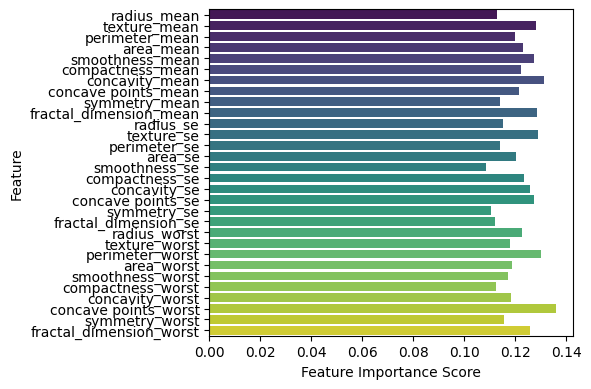

In [110]:

feature_importance = np.mean(np.abs(weights), axis=1)
column = df.drop(columns=['diagnosis'])
feature_names = column.columns

for i, importance in enumerate(feature_importance):
    print(f"Feature {i}: {importance}")

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [111]:
best_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 80)        │      2,480 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         31 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 96)        │      7,776 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 97)        │          0 │ dense_14[0][0],   │
│ (Concatenate)       │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         98 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,157 (121.71 KB)

 Trainable params: 10,385 (40.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,772 (81.14 KB)

In [112]:
explainer = shap.Explainer(best_model, x_train)

if hasattr(x_test_adapt, 'numpy'):
    x_test_adapt = x_test_adapt.numpy()
shap_values = explainer(x_test_adapt)

PermutationExplainer explainer: 115it [00:29,  3.40it/s]                         


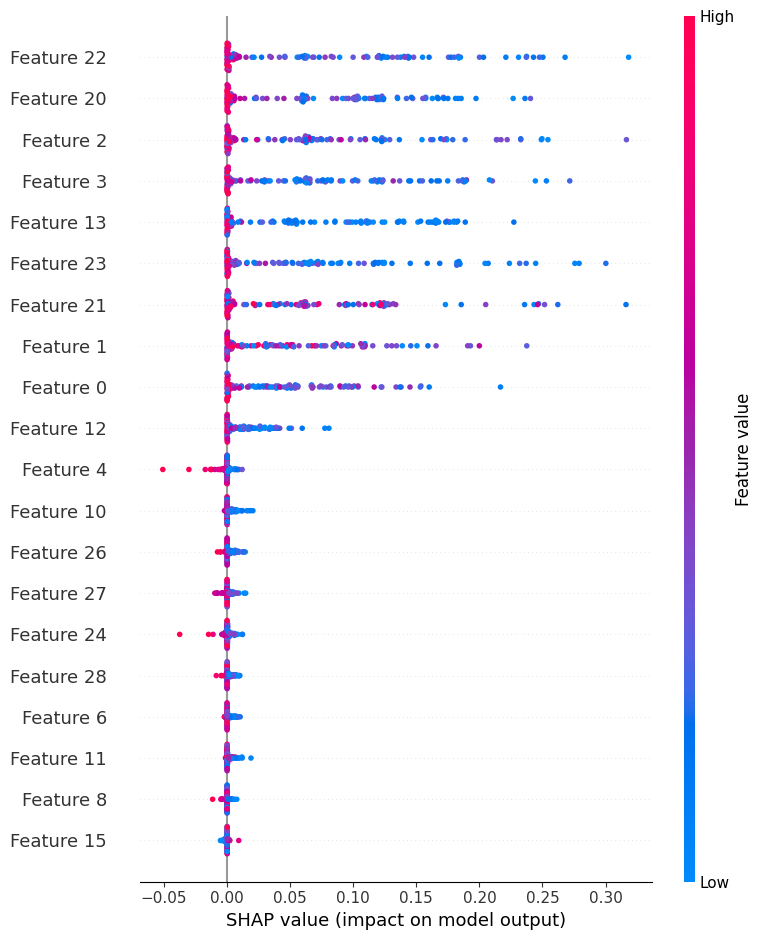

In [113]:
shap.summary_plot(shap_values.values, x_test_adapt)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\cancerpredict.csv")
prediksi.head()

In [ ]:
probabilitas_prediksi = best_model.predict(prediksi.values)
y_prediksi = (probabilitas_prediksi >= 0.5).astype(int)
print(probabilitas_prediksi)
print(y_prediksi)